<a href="https://colab.research.google.com/github/AlexandreLarget/advanced_computer_vision/blob/main/05_ACV_ResNet_fruit360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the data

In [ ]:
import os
from glob import glob

In [ ]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 25.73 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Checking out files: 100% (90503/90503), done.


In [ ]:
!ls

Fruit-Images-Dataset  sample_data


In [ ]:
!ls Fruit-Images-Dataset

LICENSE  papers  readme.md  src  Test  test-multiple_fruits  Training


In [ ]:
train_path = "Fruit-Images-Dataset/Training"
valid_path = "Fruit-Images-Dataset/Test"

In [ ]:
image_files = glob(train_path + "/*/*.jp*g")
valid_image_files = glob(valid_path + "/*/*.jp*g")

In [ ]:
folders = glob(train_path + "/*")

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
import numpy as np

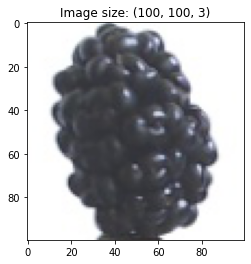

In [ ]:
sample = image.img_to_array(image.load_img(np.random.choice(image_files))).astype("uint8")
plt.imshow(sample)
plt.title(f"Image size: {sample.shape}");

# Build the model

In [ ]:
IMAGE_SIZE = [100, 100]
epochs = 16
batch_size = 128

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [ ]:
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights="imagenet", include_top=False)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
for layer in res.layers:
  layer.trainable = False

In [ ]:
x = layers.Flatten()(res.output)
x = layers.Dense(512, activation="relu")(x)
prediction = layers.Dense(len(folders), activation="softmax")(x)

model = tf.keras.Model(res.input, prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Create generator

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

In [ ]:
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)

Found 22688 images belonging to 131 classes.


In [ ]:
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

In [ ]:
labels[:5]

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3']

min -75.939 max 151.061


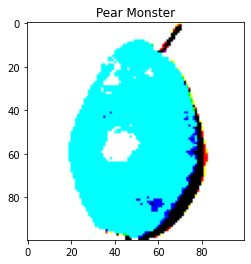

In [ ]:
for x, y in test_gen:
  print("min", x[0].min(), "max", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  break

In [ ]:
train_generator = train_gen.flow_from_directory(train_path, target_size=IMAGE_SIZE,
                                          shuffle=True, batch_size=32, class_mode="categorical")

valid_generator = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, shuffle=False,
                                              batch_size=32, class_mode="categorical")

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
r = model.fit(train_generator, validation_data=valid_generator,
              epochs=3, steps_per_epoch=len(image_files) // 32,
              validation_steps=len(valid_image_files) // 32)

Epoch 1/3
2115/2115 [==============================] - 267s 125ms/step - loss: 0.5256 - accuracy: 0.8906 - val_loss: 0.5184 - val_accuracy: 0.9167
Epoch 2/3
2115/2115 [==============================] - 249s 118ms/step - loss: 0.2245 - accuracy: 0.9579 - val_loss: 0.6748 - val_accuracy: 0.9372
Epoch 3/3
2115/2115 [==============================] - 248s 117ms/step - loss: 0.2199 - accuracy: 0.9693 - val_loss: 0.5180 - val_accuracy: 0.9475


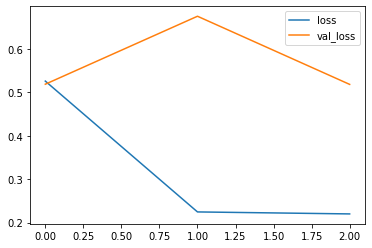

In [ ]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend();

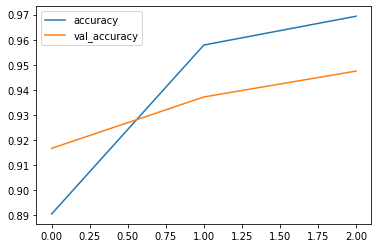

In [ ]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend();